# BTC Realized Volatility

In [56]:
import ccxt
import time
import pandas as pd
import numpy as np
import arch
import datetime as dt
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import plotly.express as px

In [63]:
# Get Bitcoin daily OHLC data 
def run_query(exchange, symbol, timeframe, from_ts):
    ohlcv_list = []
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=from_ts, limit=1000)
    ohlcv_list.extend(ohlcv)
    count = 2
    while True:
        print('API call ', count)
        from_ts = ohlcv[-1][0]
        new_ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=from_ts, limit=1000)
        ohlcv.extend(new_ohlcv)
        if len(new_ohlcv) < 500:
            break
        time.sleep(5)
        count += 1
    return ohlcv_list


# from ccxt binance
# Define parameters
symbol = 'BTC/USD:BTC'
timeframe = '1d'
# limit = 3000
exchange = ccxt.bitmex()

# Get OHLC data from Binance
start_timestamp = exchange.parse8601('2011-01-01 00:00:00')
ohlcv = run_query(exchange, symbol, timeframe, start_timestamp)
# ohlcv = exchange.fetch_ohlcv(symbol=symbol, timeframe=timeframe, limit=limit)
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

# from coingecko
# resp = requests.get('https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=365')
# data = resp.json()['prices']
# df = pd.DataFrame(data, columns=['timestamp', 'close'])
# df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
# df.set_index('timestamp', inplace=True)

# df = pd.read_csv('BTC_daily.csv', parse_dates=['Date'], index_col='Date')

# df.columns = [x.lower() for x in df.columns]

API call  2
API call  3
API call  4


In [61]:
df.head()
# df.tail()
# ohlcv
# exchange.parse8601('2018-07-21 00:00:00')
# ex = ccxt.bybit()
# ex.symbols
# exchange.symbols

,open,high,low,close,volume
timestamp,,,,,
2018-11-14,5740.0,5740.0,5241.0,5601.5,2675.936708
2018-11-15,5601.5,5638.0,5186.5,5579.0,3674.823162
2018-11-16,5579.0,5610.0,5406.5,5509.5,2369.508950
2018-11-17,5509.5,5554.5,5451.0,5501.5,1240.535548
2018-11-18,5501.5,5669.0,5501.5,5556.0,2065.989130


In [47]:
window_size = 30 # in days

# Compute annualized realized volatility rolling window using Close to close
df['log_return'] = np.log(df['close'] / df['close'].shift(1))
df['realized_vol'] = 100 * np.sqrt(365 / window_size * df['log_return'].rolling(window_size).std())

# Compute annualized realized volatility Garman Klass model with rolling window
df['gamma'] = 0.5 * np.log(df['high'] / df['low']) ** 2 - (2 * np.log(2) - 1) * np.log(
    df['close'] / df['open']) ** 2
df['gk_vol'] = 100 * np.sqrt(df['gamma'].rolling(window_size).sum() / (window_size - 1)) * np.sqrt(365)

df.dropna(inplace=True)
# Compute the annualized GARCH volatility using a rolling window
garch_model = arch.arch_model(df['log_return'], vol='GARCH', p=1, q=1)
garch_volatility = garch_model.fit(disp='off').conditional_volatility
df['garch_vol'] = 100 * garch_volatility * np.sqrt(365)

# Compute the annualized HAR volatility with a rolling window
df['volatility_5d'] = df['log_return'].rolling(5).std() * np.sqrt(365)
df['volatility_21d'] = df['log_return'].rolling(21).std() * np.sqrt(365)
df['volatility_63d'] = df['log_return'].rolling(63).std() * np.sqrt(365)
df['har_vol'] = 100 * np.sqrt(0.5 * (0.5 * df['volatility_5d']**2 + 0.3 * df['volatility_21d']**2 + 0.2 * df['volatility_63d']**2))

# Compute rolling window annualized volatility using EGARCH model
egarch_vol = arch.arch_model(df['log_return'], vol='egarch', p=1, o=1, q=1, dist='Normal').fit(disp='off').conditional_volatility
df['egarch_vol'] = 100 * np.sqrt(365) * egarch_vol.rolling(window=window_size).mean()

# Compute rolling window annualized volatility using GJR-GARCH model
gjr_vol = arch.arch_model(df['log_return'], vol='garch', p=1, o=1, q=1, dist='Normal', power=1.0).fit(disp='off').conditional_volatility
df['gjr_vol'] = 100 * np.sqrt(365) * gjr_vol.rolling(window=window_size).mean()

df.dropna(inplace=True)


/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:310: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001862. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:310: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001862. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/opt/anaconda3/lib/python3.9/site-packages/arch/univariate/base.py:310: DataScaleWarning:

y is poorly scaled,

In [48]:
df.head()

,open,high,low,close,volume,log_return,realized_vol,gamma,gk_vol,garch_vol,volatility_5d,volatility_21d,volatility_63d,har_vol,egarch_vol,gjr_vol
timestamp,,,,,,,,,,,,,,,,
2015-12-26,455.44,458.45,402.86,416.76,2993927.0,-0.088753,68.164483,0.005311,85.902766,46.825024,0.879824,0.753598,0.860122,59.387722,77.501861,73.231497
2015-12-27,416.76,433.95,407.83,426.82,1267415.0,0.023852,68.203998,0.001707,86.413856,89.064175,0.929403,0.756383,0.861111,61.311972,77.582862,73.267476
2015-12-28,426.82,432.67,417.87,422.50,1865178.0,-0.010173,68.253945,0.000566,86.400616,81.574293,0.892609,0.756557,0.861899,59.944281,77.682756,73.328780
2015-12-29,422.50,434.97,418.26,434.00,1033533.0,0.026855,67.485861,0.000489,85.512047,73.787950,0.893022,0.716392,0.862209,59.219509,77.811190,73.426966
2015-12-30,434.00,434.47,419.97,424.00,841044.0,-0.023311,67.792967,0.000366,85.203733,69.382056,0.895637,0.723612,0.862160,59.448760,77.593064,73.222085


In [49]:
fig = px.line(df, x=df.index, y=['realized_vol', 'gk_vol', 'har_vol', 'egarch_vol',
#                                  'gjr_vol'
                                ],
              title='Bitcoin Annualized Realized Volatility',
              labels={'value': 'Volatility', 'variable': 'Method'})
fig.update_xaxes(title='Date')
# fig.update_yaxes(tickformat=)
fig.show()

### Historical vol box plot

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

              Volume  LogReturns  RealizedVolatility  Year  
Date                                                        
2014-09-17  21056800         NaN                 NaN  2014  
2014-09-18  34483200   -0.074643                 NaN  2014  
2014-09-19  37919700   -0.072402                 NaN  2014  
2014-09-20  36863600    0.035111                 NaN  2014  
2014-09-21  26580100   -0.024968                 NaN  2014  


<Figure size 1000x600 with 0 Axes>

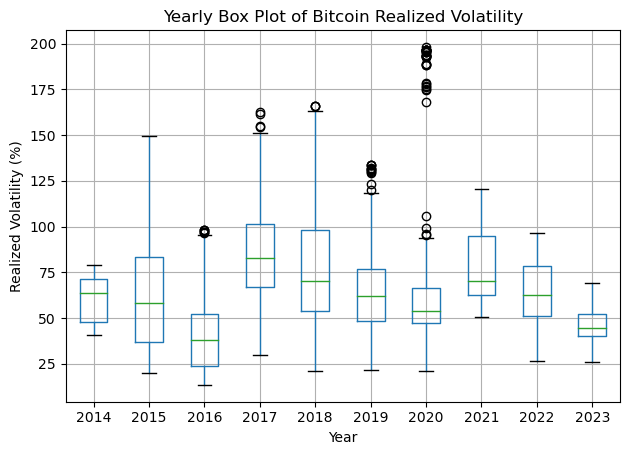

In [68]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get Bitcoin daily prices since 2013
# btc_data = yf.download('BTC-USD', start='2013-01-01')

# Print a sample of the data
print(btc_data.head())

# Compute log returns
btc_data['LogReturns'] = np.log(btc_data['Close'] / btc_data['Close'].shift(1))

# Compute 30-day rolling realized volatility in percentage
btc_data['RealizedVolatility'] = btc_data['LogReturns'].rolling(window=30).std() * np.sqrt(365) * 100

# Plot a box plot of realized volatility year-wise
btc_data['Year'] = btc_data.index.year
plt.figure(figsize=(10, 6))
btc_data.boxplot(column='RealizedVolatility', by='Year')
plt.title('Yearly Box Plot of Bitcoin Realized Volatility')
plt.xlabel('Year')
plt.ylabel('Realized Volatility (%)')
plt.suptitle('')  # Remove the automatically generated title
plt.tight_layout()
plt.show()


             Price
Timestamp         
2013-04-28  135.30
2013-04-29  141.96
2013-04-30  135.30
2013-05-01  117.00
2013-05-02  103.43


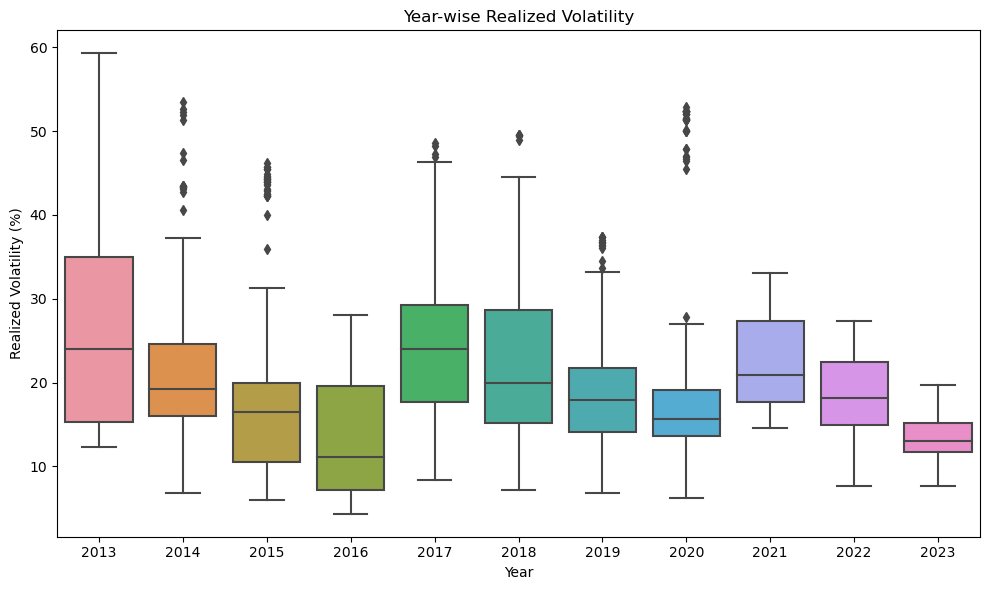

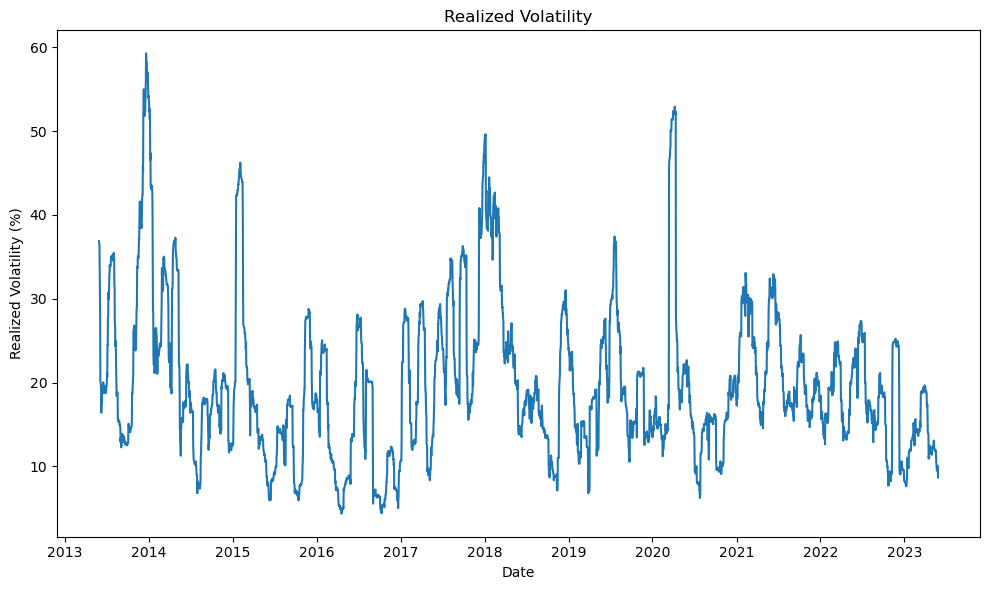

In [69]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Fetch Bitcoin daily prices since 2011 using CoinGecko API
url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
params = {"vs_currency": "usd", "days": "max"}
response = requests.get(url, params=params)
data = response.json()
prices = data["prices"]

# Convert the data to a pandas DataFrame
df = pd.DataFrame(prices, columns=["Timestamp", "Price"])
df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit="ms")
df.set_index("Timestamp", inplace=True)

# Print sample of the data
print(df.head())

# Compute log returns
df["Returns"] = np.log(df["Price"] / df["Price"].shift(1))

# Compute 30-day rolling realized volatility in percentage
df["Realized Volatility"] = df["Returns"].rolling(window=30).std() * np.sqrt(30) * 100

# Plot an attractive box plot of realized volatility year-wise
df["Year"] = df.index.year
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Year", y="Realized Volatility")
plt.xlabel("Year")
plt.ylabel("Realized Volatility (%)")
plt.title("Year-wise Realized Volatility")
plt.tight_layout()
plt.show()

# Plot realized volatility on a line chart
plt.figure(figsize=(10, 6))
plt.plot(df.index, df["Realized Volatility"])
plt.xlabel("Date")
plt.ylabel("Realized Volatility (%)")
plt.title("Realized Volatility")
plt.tight_layout()
plt.show()


             Price
Timestamp         
2013-04-28  135.30
2013-04-29  141.96
2013-04-30  135.30
2013-05-01  117.00
2013-05-02  103.43


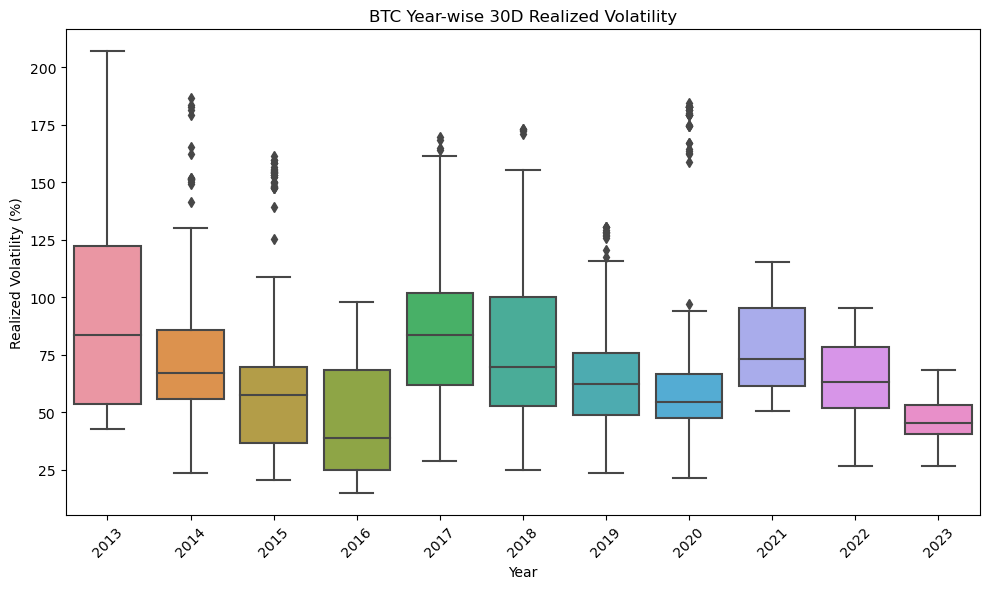

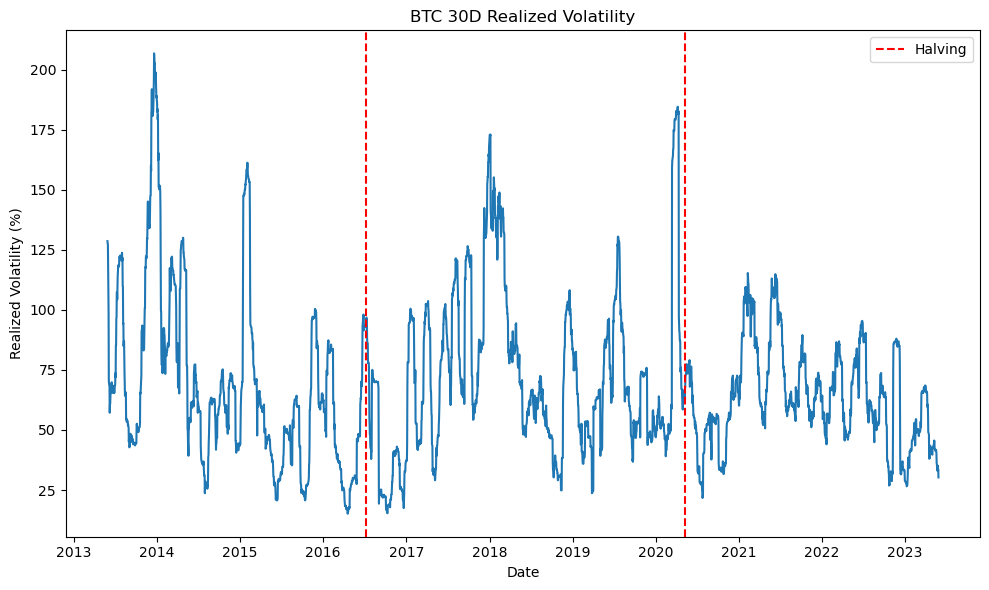

In [76]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Fetch Bitcoin daily prices since 2011 using CoinGecko API
url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
params = {"vs_currency": "usd", "days": "max"}
# response = requests.get(url, params=params)
# data = response.json()
# prices = data["prices"]

# Convert the data to a pandas DataFrame
df = pd.DataFrame(prices, columns=["Timestamp", "Price"])
df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit="ms")
df.set_index("Timestamp", inplace=True)

# Print sample of the data
print(df.head())

# Compute log returns
df["Returns"] = np.log(df["Price"] / df["Price"].shift(1))

# Compute 30-day rolling realized volatility in percentage
df["Realized Volatility"] = df["Returns"].rolling(window=30).std() * np.sqrt(365) * 100

# Get halving dates
halving_dates = ["2016-07-09", "2020-05-11"]

# Plot an attractive box plot of realized volatility year-wise
df["Year"] = df.index.year
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Year", y="Realized Volatility")
plt.xlabel("Year")
plt.ylabel("Realized Volatility (%)")
plt.title("BTC Year-wise 30D Realized Volatility")
plt.xticks(rotation=45)
plt.tight_layout()

# Add vertical lines for halving events
# for date, label in zip(halving_dates, halving_labels):
#     plt.axvline(pd.to_datetime(date), color='red', linestyle='--', label=label)

# plt.legend()
plt.show()

# Plot realized volatility on a line chart
plt.figure(figsize=(10, 6))
plt.plot(df.index, df["Realized Volatility"])
plt.xlabel("Date")
plt.ylabel("Realized Volatility (%)")
plt.title("BTC 30D Realized Volatility")
plt.tight_layout()

# Add vertical lines for halving events
plt.axvline(pd.to_datetime(halving_dates[0]), color='red', linestyle='--', label='Halving')
plt.axvline(pd.to_datetime(halving_dates[1]), color='red', linestyle='--')

plt.legend()
plt.show()


In [79]:
import pyflowchart

# Create a new flowchart object
flowchart = pyflowchart.Flowchart()

# Add a start node
start = flowchart.add_node("Start")

# Add a data feed node
data_feed = flowchart.add_node("Data Feed")

# Add a strategy node
strategy = flowchart.add_node("Strategy")

# Add an execution node
execution = flowchart.add_node("Execution")

# Add a risk management node
risk_management = flowchart.add_node("Risk Management")

# Add a portfolio management node
portfolio_management = flowchart.add_node("Portfolio Management")

# Add an end node
end = flowchart.add_node("End")

# Connect the nodes
flowchart.connect(start, data_feed)
flowchart.connect(data_feed, strategy)
flowchart.connect(strategy, execution)
flowchart.connect(execution, risk_management)
flowchart.connect(risk_management, portfolio_management)
flowchart.connect(portfolio_management, end)

# Add a decision node
decision = flowchart.add_node("Decision")

# Connect the decision node to the execution and risk management nodes
flowchart.connect(decision, execution)
flowchart.connect(decision, risk_management)

# Add a condition to the decision node
condition = flowchart.add_condition(decision, "Is the market in a bull market?")

# Add a true branch to the decision node
true_branch = flowchart.add_true_branch(condition)

# Add a false branch to the decision node
false_branch = flowchart.add_false_branch(condition)

# Connect the true branch to the execution node
flowchart.connect(true_branch, execution)

# Connect the false branch to the risk management node
flowchart.connect(false_branch, risk_management)

# Add a loop node
loop = flowchart.add_node("Loop")

# Connect the loop node to the strategy node
flowchart.connect(loop, strategy)

# Add a condition to the loop node
condition = flowchart.add_condition(loop, "Is the market still in a bull market?")

# Add a true branch to the loop node
true_branch = flowchart.add_true_branch(condition)

# Add a false branch to the loop node
false_branch = flowchart.add_false_branch(condition)

# Connect the true branch to the loop node
flowchart.connect(true_branch, loop)

# Connect the false branch to the end node
flowchart.connect(false_branch, end)

# Render the flowchart
flowchart.render("options_market_making.png")


TypeError: __init__() missing 1 required positional argument: 'head_node'